# MODIS Water Exploratory Data Analysis

Used for EDA of the training data generated into tabular formats.

Version: 09.07.2021

editing: Amanda Burke February 2023

In [2]:
import csv
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
TEST_RATIO = 0.2
TILE = 'h16v02'
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.float32
colsToDrop = ['Unnamed: 0', 'x_offset', 'y_offset']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']


##########################
#Data paths, can get access to them thorugh terminal at /explore/ have to cd ../../ to get there though
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

glob_string = training_data_basepath+'MOD09*{}*all.csv'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
pprint(data_paths)

[]


In [3]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [4]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v2.0.0/MOD09*{}*all.csv'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
pprint(data_paths)

[]


In [9]:
data_idx = 0
data_path = data_paths[data_idx]
os.path.exists(data_path)

True

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [10]:
%%time
df = load_data(fpath=data_path, 
               colsToDrop=colsToDrop, 
               splitXY=False, 
               trainTestSplit=False, 
               imbalance=False,
               multi=False)

CPU times: user 22 s, sys: 5.34 s, total: 27.4 s
Wall time: 37.7 s


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15411703 entries, 0 to 15574251
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   water           float32
 1   sur_refl_b01_1  float32
 2   sur_refl_b02_1  float32
 3   sur_refl_b03_1  float32
 4   sur_refl_b04_1  float32
 5   sur_refl_b05_1  float32
 6   sur_refl_b06_1  float32
 7   sur_refl_b07_1  float32
 8   ndvi            float32
 9   ndwi1           float32
 10  ndwi2           float32
 11  year            float32
 12  julian_day      float32
dtypes: float32(13)
memory usage: 881.9 MB


In [12]:
#df.describe().T.to_csv('output/{}_outputInfo.csv'.format(TILE))
df.describe().T

,count,mean,std,min,25%,50%,75%,max
water,15411703.0,0.389907,0.487729,0.0,0.000000,0.000000,1.000000,1.0
sur_refl_b01_1,15411703.0,393.663086,566.160583,-100.0,-4.000000,387.000000,602.000000,16000.0
sur_refl_b02_1,15411703.0,1083.076782,1032.860840,-100.0,1.000000,1205.000000,1923.000000,16000.0
sur_refl_b03_1,15411703.0,272.307953,499.926086,-100.0,99.000000,202.000000,312.000000,15848.0
sur_refl_b04_1,15411703.0,387.686279,521.798035,-100.0,82.000000,367.000000,530.000000,16000.0
sur_refl_b05_1,15411703.0,1426.337769,1260.599609,-100.0,12.000000,1696.000000,2541.000000,16000.0
sur_refl_b06_1,15411703.0,1326.769165,1119.626953,-100.0,87.000000,1564.000000,2311.000000,16000.0
sur_refl_b07_1,15411703.0,766.818970,683.251282,-100.0,53.000000,843.000000,1286.000000,15277.0
ndvi,15411703.0,791.366821,21426.394531,-2010000.0,-2911.392334,4220.907227,5736.374023,2010000.0
ndwi1,15411703.0,-4576.310547,34353.593750,-2010000.0,-9204.771484,-1785.714233,-423.116608,1990000.0


In [13]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df.sample(frac=0.1)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541170 entries, 447620 to 2019563
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   water           1541170 non-null  float32
 1   sur_refl_b01_1  1541170 non-null  float32
 2   sur_refl_b02_1  1541170 non-null  float32
 3   sur_refl_b03_1  1541170 non-null  float32
 4   sur_refl_b04_1  1541170 non-null  float32
 5   sur_refl_b05_1  1541170 non-null  float32
 6   sur_refl_b06_1  1541170 non-null  float32
 7   sur_refl_b07_1  1541170 non-null  float32
 8   ndvi            1541170 non-null  float32
 9   ndwi1           1541170 non-null  float32
 10  ndwi2           1541170 non-null  float32
 11  year            1541170 non-null  float32
 12  julian_day      1541170 non-null  float32
dtypes: float32(13)
memory usage: 88.2 MB


### Coorelation plots with water points as orange
#### This will take more than 15 mins to run.

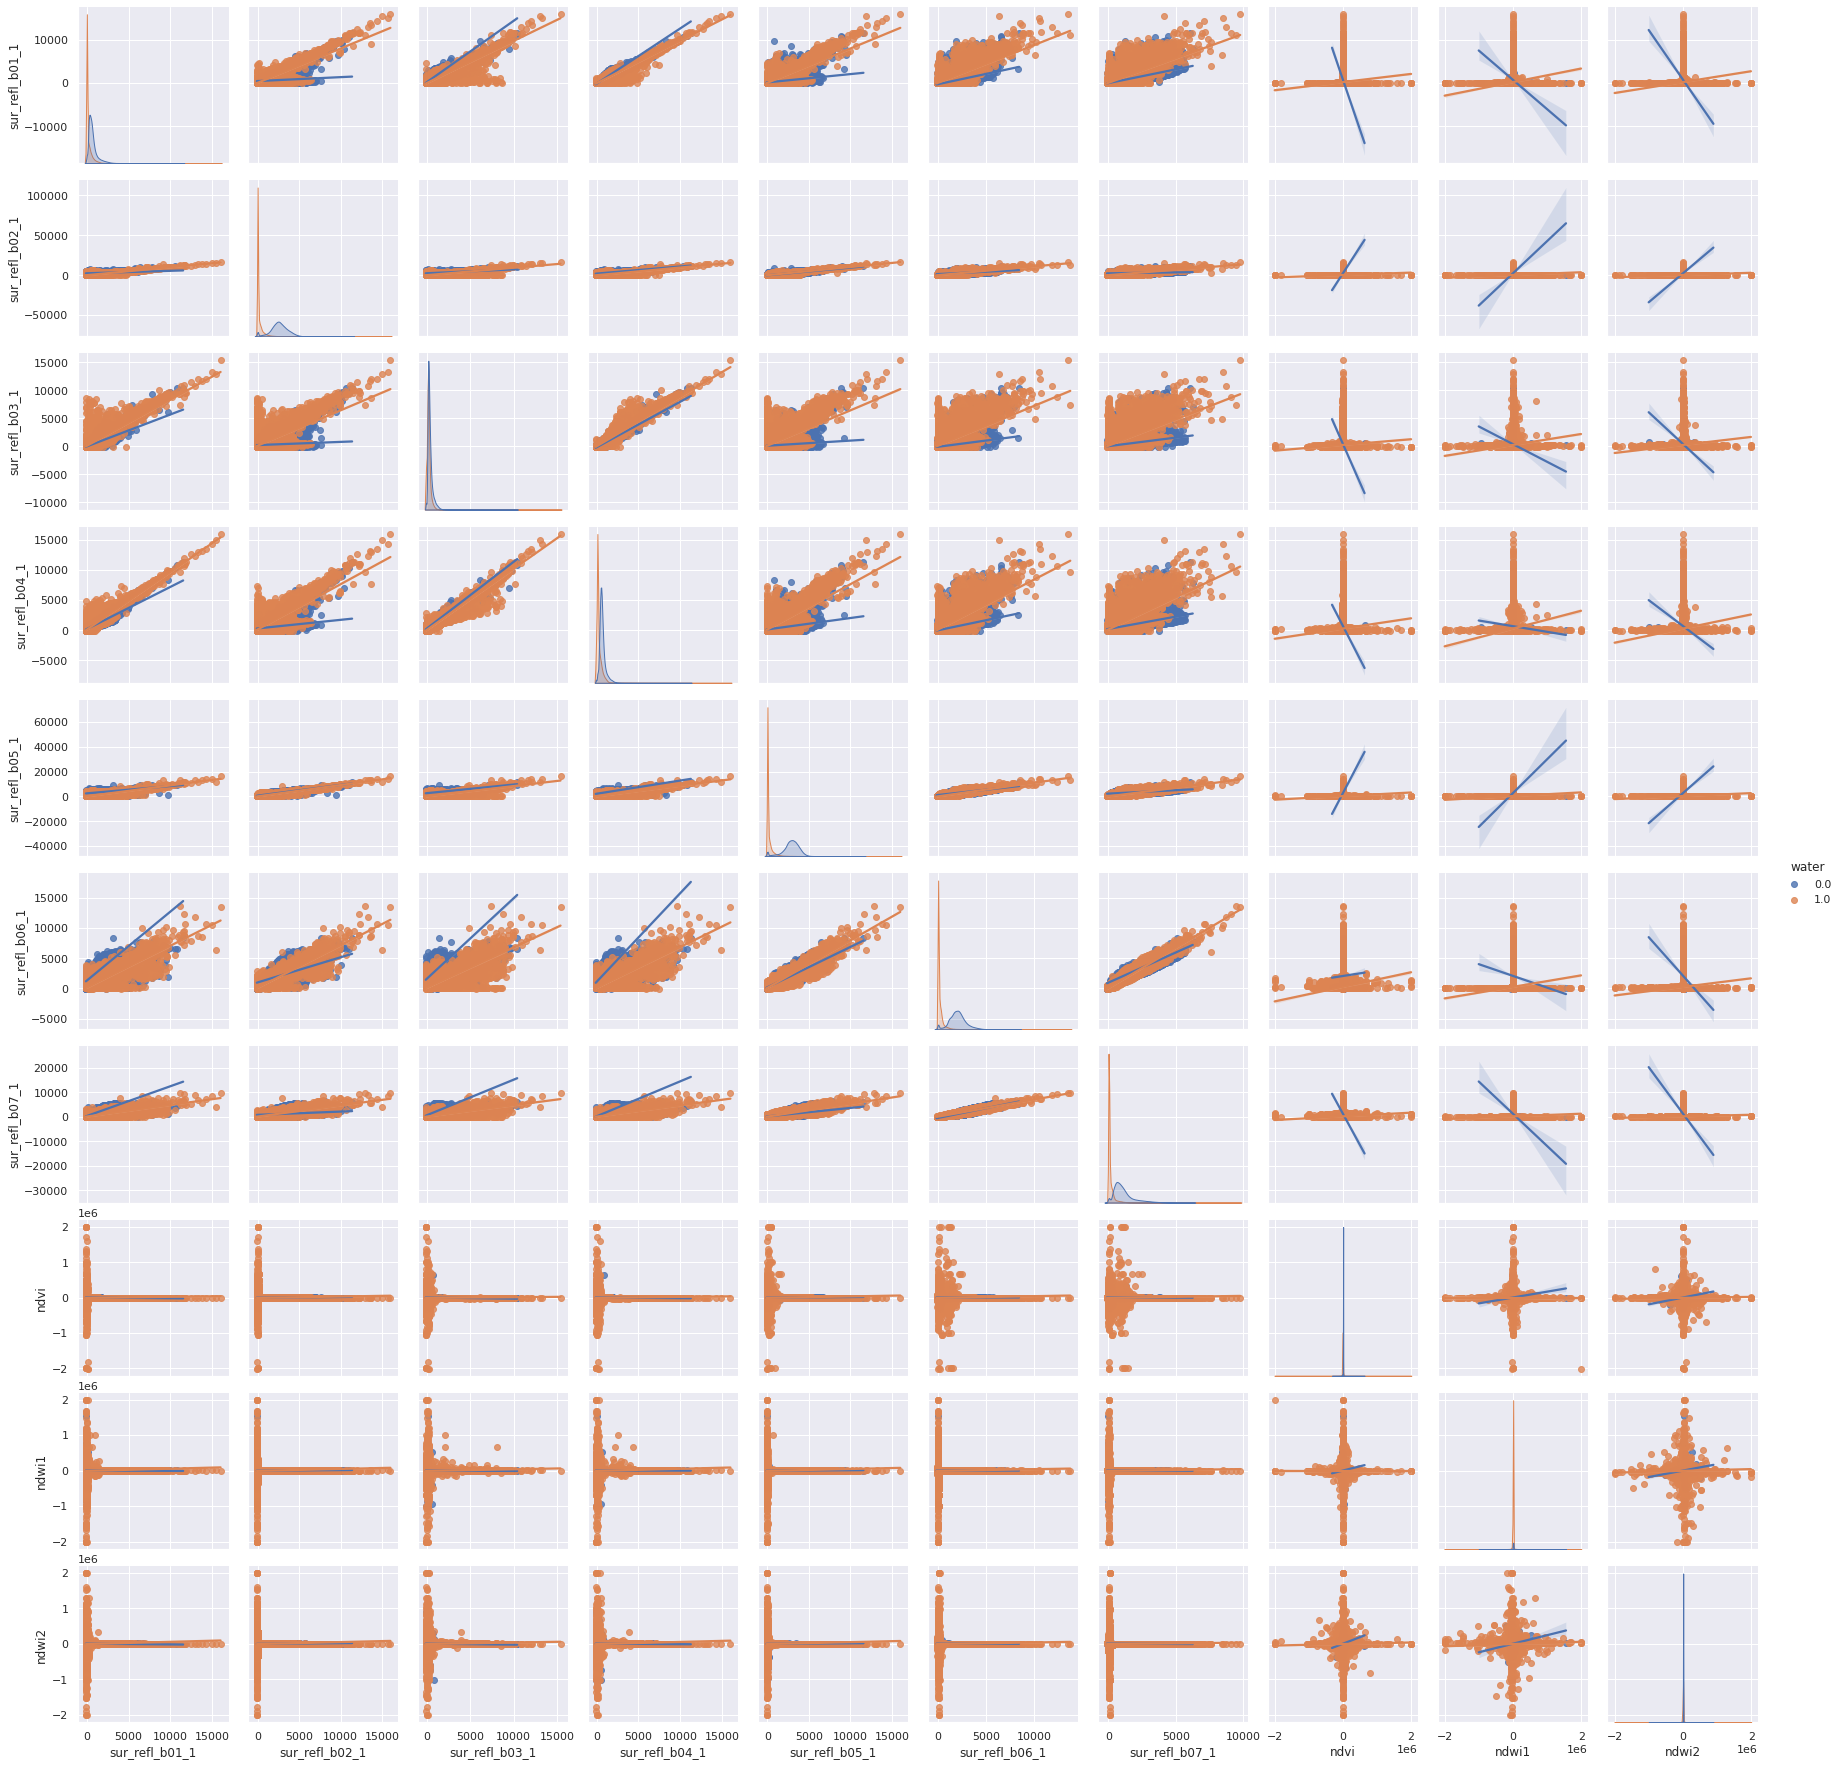

In [8]:
sns.set()
sns.pairplot(sampledDf, hue='water', kind='reg')
plt.savefig('output/{}_modisWaterTrainingEDA_Correlation_WaterHighlight.png'.format(TILE))

### Distribution for each channel

array([[<AxesSubplot:title={'center':'water'}>,
        <AxesSubplot:title={'center':'sur_refl_b01_1'}>,
        <AxesSubplot:title={'center':'sur_refl_b02_1'}>,
        <AxesSubplot:title={'center':'sur_refl_b03_1'}>],
       [<AxesSubplot:title={'center':'sur_refl_b04_1'}>,
        <AxesSubplot:title={'center':'sur_refl_b05_1'}>,
        <AxesSubplot:title={'center':'sur_refl_b06_1'}>,
        <AxesSubplot:title={'center':'sur_refl_b07_1'}>],
       [<AxesSubplot:title={'center':'ndvi'}>,
        <AxesSubplot:title={'center':'ndwi1'}>,
        <AxesSubplot:title={'center':'ndwi2'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'julian_day'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

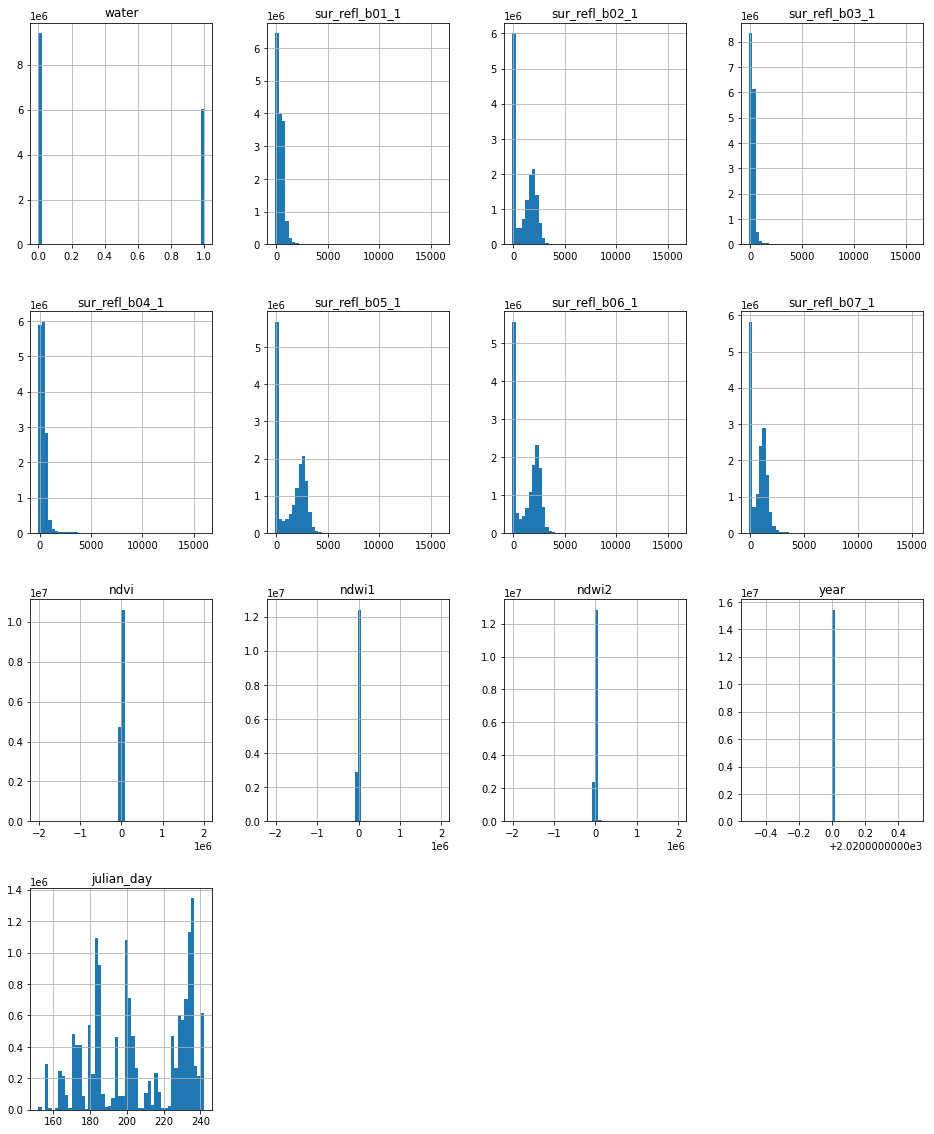

In [15]:
df.hist(figsize=(16, 20), bins=50)
#plt.savefig('output/{}_histDF.png'.format(TILE))

### Correlation calculations

In [16]:
# correlation with dataset - target value
corr = df.corr()['water']
#corr.to_csv('output/{}_correlation.csv'.format(TILE))
corr

water             1.000000
sur_refl_b01_1   -0.381212
sur_refl_b02_1   -0.736517
sur_refl_b03_1   -0.056084
sur_refl_b04_1   -0.284001
sur_refl_b05_1   -0.819841
sur_refl_b06_1   -0.813928
sur_refl_b07_1   -0.745392
ndvi             -0.236276
ndwi1            -0.119959
ndwi2            -0.121856
year                   NaN
julian_day       -0.063987
Name: water, dtype: float64

In [17]:
# full correlation table
df.corr().style.background_gradient(cmap='viridis')

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,year,julian_day
water,1.000000,-0.381212,-0.736517,-0.056084,-0.284001,-0.819841,-0.813928,-0.745392,-0.236276,-0.119959,-0.121856,nan,-0.063987
sur_refl_b01_1,-0.381212,1.000000,0.763061,0.862323,0.948766,0.650518,0.667234,0.725337,0.104148,0.085705,0.080145,nan,-0.004322
sur_refl_b02_1,-0.736517,0.763061,1.000000,0.470214,0.666441,0.936711,0.911954,0.860018,0.201627,0.122207,0.122908,nan,0.026152
sur_refl_b03_1,-0.056084,0.862323,0.470214,1.000000,0.948242,0.362205,0.373978,0.449124,0.033775,0.044564,0.039341,nan,-0.038607
sur_refl_b04_1,-0.284001,0.948766,0.666441,0.948242,1.000000,0.584187,0.595631,0.656906,0.086558,0.070542,0.065642,nan,-0.020981
sur_refl_b05_1,-0.819841,0.650518,0.936711,0.362205,0.584187,1.000000,0.981748,0.919750,0.218272,0.115090,0.115546,nan,0.020039
sur_refl_b06_1,-0.813928,0.667234,0.911954,0.373978,0.595631,0.981748,1.000000,0.969885,0.213195,0.110627,0.109178,nan,-0.001529
sur_refl_b07_1,-0.745392,0.725337,0.860018,0.449124,0.656906,0.919750,0.969885,1.000000,0.191036,0.102256,0.095579,nan,-0.010979
ndvi,-0.236276,0.104148,0.201627,0.033775,0.086558,0.218272,0.213195,0.191036,1.000000,0.032610,0.037283,nan,0.004230
ndwi1,-0.119959,0.085705,0.122207,0.044564,0.070542,0.115090,0.110627,0.102256,0.032610,1.000000,0.038024,nan,0.006522


## Distributions

ValueError: num must be 1 <= num <= 12, not 13

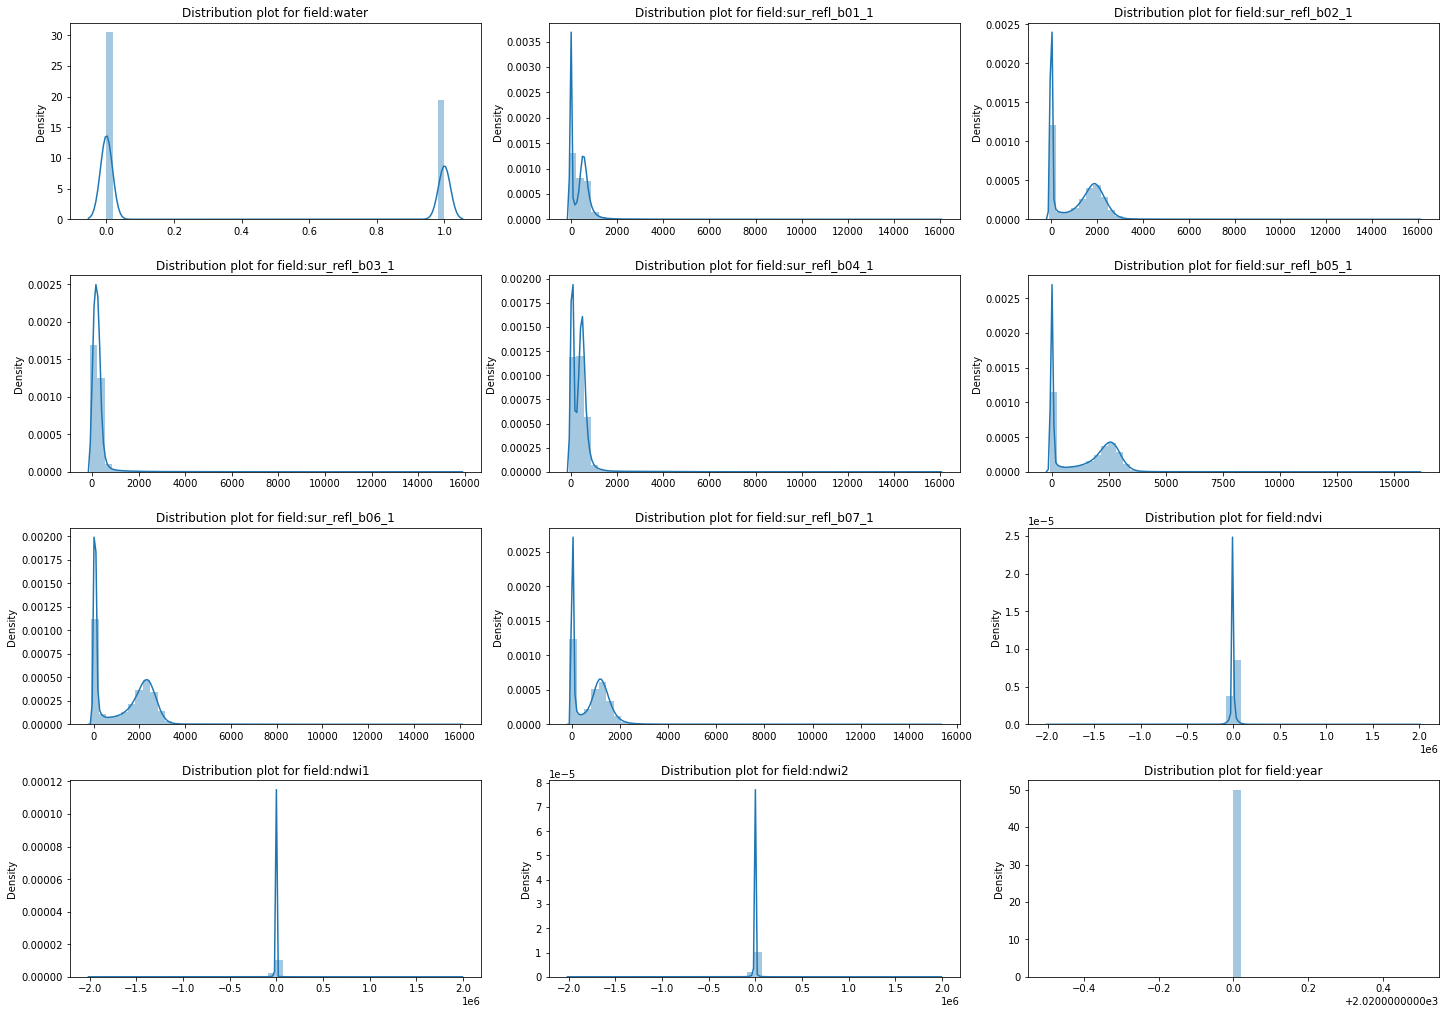

In [18]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig('output/{}_output_dist_modis_water.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b01_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b01_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b02_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b03_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b04_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b04_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b05_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b05_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b06_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b06_dist.png'.format(TILE))

In [ ]:
df.hist(column='sur_refl_b07_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b07_dist.png'.format(TILE))

In [ ]:
df.hist(column='ndvi', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=True)

In [ ]:
df.hist(column='ndwi1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

In [ ]:
df.hist(column='ndwi2', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)